***With the given various features, the aim is to build a predictive model to determine the income level for people in US which are classed at below 50K and above 50K.***

[Data Source](http://archive.ics.uci.edu/ml/machine-learning-databases/census-income-mld/?C=N;O=D)

### Importing the basic prerequisite libraries as of now

In [1]:
%%time

import pandas as pd, numpy as np, matplotlib.pyplot as plt, tensorflow as tf, seaborn as sns

import warnings
warnings.filterwarnings("ignore")

CPU times: user 816 ms, sys: 6.73 s, total: 7.54 s
Wall time: 7.59 s


In [2]:
# Crosschecking GPU availability
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('GPU available. \nName: {}'.format(device_name))

GPU available. 
Name: /device:GPU:0


In [3]:
%%time
!pip install -q pydrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# get the file
downloaded = drive.CreateFile({'id':'1G1hmM2FWk1w2_biDOBLV88KRbbZOz-VS'}) # replace the id with id of file you want to access
downloaded.GetContentFile('train.csv')  

downloaded2 = drive.CreateFile({'id':'1eLc4Ch1nOYg3-GrKHVfMrQBl_B8Ueg2L'}) # replace the id with id of file you want to access
downloaded2.GetContentFile('test.csv')  


# read file as panda dataframe
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

CPU times: user 3.14 s, sys: 642 ms, total: 3.78 s
Wall time: 41.2 s


### Understanding the data to look at the big picture for better insights moving forward.

In [4]:
# train.head()
# test.head()

print("train", train.shape)
print("test", test.shape)

train (199523, 41)
test (99762, 41)


In [0]:
# train.isnull().any()

# Turns out all the features with null values are nominal in nature, which are:

# hispanic_origin                      
# state_of_previous_residence          
# migration_sunbelt      
# country_father
# country_mother
# country_self 


# test.isnull().any()
# test data has no features with null values

In [6]:
# Analyzing the target feature

print("\tTRAIN\n",train.income_level.describe(), train.income_level.unique())
print("\tTEST\n",test.income_level.describe(), test.income_level.unique())

	TRAIN
 count    199523.000000
mean     -43794.199165
std       24126.148404
min      -50000.000000
25%      -50000.000000
50%      -50000.000000
75%      -50000.000000
max       50000.000000
Name: income_level, dtype: float64 [-50000  50000]
	TEST
 count      99762
unique         2
top       -50000
freq       93576
Name: income_level, dtype: object ['-50000' ' 50000+.']


In [7]:
# # # # We can see that the classes in train and test are represented differently, so we can use 0 and 1 to represent the classes


train.income_level.replace({-50000:0,50000:1},inplace=True)
train.income_level.unique()

test['income_level'] = test.income_level.map( lambda x: 0 if x == '-50000' else 1)
test.income_level.unique()

array([0, 1])

##### ** Filling in the null values with the most frequently occurring values [mode] as all of these are categorical features.**

In [0]:
# print(train.isnull().sum()*100/199523)

# hispanic_origin                      0.438045 % is null values
# state_of_previous_residence          0.354846 % is null values

# migration_msa                       49.967172 % is null values
# migration_reg                       49.967172 % is null values
# migration_within_reg                49.967172 % is null values
# migration_sunbelt                   49.967172 % is null values

# country_father                       3.364524 % is null values
# country_mother                       3.066814 % is null values
# country_self                         1.700556 % is null values

# We will have to deal with these missing features before training the model!

In [9]:
train.hispanic_origin.fillna('All other',inplace=True)
train.state_of_previous_residence.fillna('Not in universe', inplace=True)
train.country_father.fillna('United-States', inplace=True)
train.country_mother.fillna('United-States', inplace=True)
train.country_self.fillna('United-States', inplace=True)

print(train.migration_msa.describe(),train.migration_reg.describe(),train.migration_within_reg.describe(),train.migration_sunbelt.describe())
train.migration_msa.fillna('Nonmover', inplace=True)
train.migration_reg.fillna('Nonmover', inplace=True)
train.migration_within_reg.fillna('Nonmover', inplace=True)
train.migration_sunbelt.fillna('Not in universe', inplace=True)

train.isnull().any() # commenting out after there are no null values across the whole dataset

count        99827
unique           9
top       Nonmover
freq         82538
Name: migration_msa, dtype: object count        99827
unique           8
top       Nonmover
freq         82538
Name: migration_reg, dtype: object count        99827
unique           9
top       Nonmover
freq         82538
Name: migration_within_reg, dtype: object count               99827
unique                  3
top       Not in universe
freq                84054
Name: migration_sunbelt, dtype: object


age                                 False
class_of_worker                     False
industry_code                       False
occupation_code                     False
education                           False
wage_per_hour                       False
enrolled_in_edu_inst_lastwk         False
marital_status                      False
major_industry_code                 False
major_occupation_code               False
race                                False
hispanic_origin                     False
sex                                 False
member_of_labor_union               False
reason_for_unemployment             False
full_parttime_employment_stat       False
capital_gains                       False
capital_losses                      False
dividend_from_Stocks                False
tax_filer_status                    False
region_of_previous_residence        False
state_of_previous_residence         False
d_household_family_stat             False
d_household_summary               

###Basic EDA

**Lets plot the labels in train and test to check the imbalance in the class label distribution.**




Occurence of Class : 0 in Train = 93.79419916500855
Occurence of Class : 1 in Train = 6.205800834991455
		


	____Train data____


(array([187141.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  12382.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

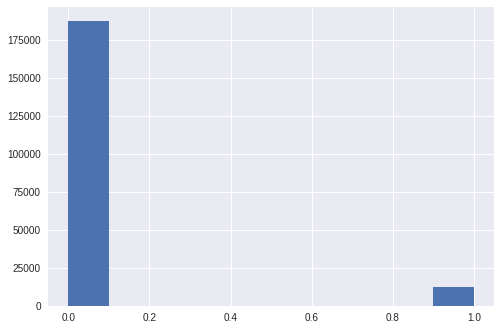

In [10]:
print('\n\n')
print(f"Occurence of Class : 0 in Train = {len(train[train['income_level']==0])*100/train['income_level'].shape[0]}")
print(f"Occurence of Class : 1 in Train = {len(train[train['income_level']==1])*100/train['income_level'].shape[0]}")


print("\t\t\n\n\n\t____Train data____")
plt.hist(train.income_level)




Occurence of Class : 0 in Test = 93.7992421964275
Occurence of Class : 1 in Test = 6.200757803572502
		


	____Test data____


(array([93576.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  6186.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

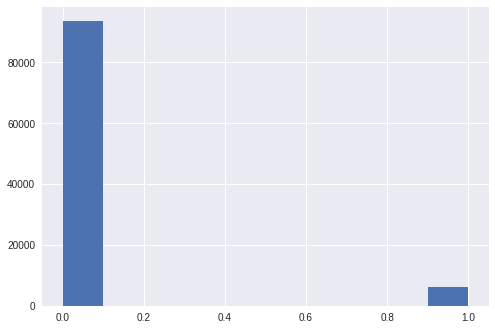

In [11]:
print('\n\n')
print(f"Occurence of Class : 0 in Test = {len(test[test['income_level']==0])*100/test['income_level'].shape[0]}")
print(f"Occurence of Class : 1 in Test = {len(test[test['income_level']==1])*100/test['income_level'].shape[0]}")


print("\t\t\n\n\n\t____Test data____")
plt.hist(test.income_level)

**The two cells above prove that the class labels are highly imbalanced, this means with a decent ML algo will always get high accuracy predicting the most frequent class, however we will need to predict the minority class nicely as well, which will be tough for an algo, thus will have to techniques which balance this dispartity moving forward.**

In [13]:
train.head()

,age,class_of_worker,industry_code,occupation_code,education,wage_per_hour,enrolled_in_edu_inst_lastwk,marital_status,major_industry_code,major_occupation_code,...,country_father,country_mother,country_self,citizenship,business_or_self_employed,fill_questionnaire_veteran_admin,veterans_benefits,weeks_worked_in_year,year,income_level
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,0
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,0
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,0
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,0
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,0


**Let's try to separate the numerical and categorical features in the dataset for better functionality and analysis moving forward.**

In [14]:
ls = ['age', 'class_of_worker', 'industry_code', 'occupation_code',
       'education', 'wage_per_hour', 'enrolled_in_edu_inst_lastwk',
       'marital_status', 'major_industry_code', 'major_occupation_code',
       'race', 'hispanic_origin', 'sex', 'member_of_labor_union',
       'reason_for_unemployment', 'full_parttime_employment_stat',
       'capital_gains', 'capital_losses', 'dividend_from_Stocks',
       'tax_filer_status', 'region_of_previous_residence',
       'state_of_previous_residence', 'd_household_family_stat',
       'd_household_summary', 'migration_msa', 'migration_reg',
       'migration_within_reg', 'live_1_year_ago', 'migration_sunbelt',
       'num_person_Worked_employer', 'family_members_under_18',
       'country_father', 'country_mother', 'country_self', 'citizenship',
       'business_or_self_employed', 'fill_questionnaire_veteran_admin',
       'veterans_benefits', 'weeks_worked_in_year', 'year', 'income_level']

df = pd.DataFrame(ls)
df

,0
0,age
1,class_of_worker
2,industry_code
3,occupation_code
4,education
5,wage_per_hour
6,enrolled_in_edu_inst_lastwk
7,marital_status
8,major_industry_code
9,major_occupation_code


In [15]:
cat_features = ['class_of_worker','industry_code', 'occupation_code', 'education', 'marital_status','major_industry_code', 'major_occupation_code',
       'race', 'hispanic_origin', 'sex', 'member_of_labor_union',
       'reason_for_unemployment', 'full_parttime_employment_stat',  'region_of_previous_residence',
       'state_of_previous_residence', 'd_household_family_stat',
       'd_household_summary', 'migration_msa', 'migration_reg',
       'migration_within_reg', 'live_1_year_ago', 'migration_sunbelt','country_father', 'country_mother', 'country_self', 'citizenship',
       'business_or_self_employed', 'fill_questionnaire_veteran_admin',
       'veterans_benefits','year', 'income_level', 'family_members_under_18', 'enrolled_in_edu_inst_lastwk', 'tax_filer_status']


cat_train = train[cat_features]

cat_train.head(1)

,class_of_worker,industry_code,occupation_code,education,marital_status,major_industry_code,major_occupation_code,race,hispanic_origin,sex,...,country_self,citizenship,business_or_self_employed,fill_questionnaire_veteran_admin,veterans_benefits,year,income_level,family_members_under_18,enrolled_in_edu_inst_lastwk,tax_filer_status
0,Not in universe,0,0,High school graduate,Widowed,Not in universe or children,Not in universe,White,All other,Female,...,United-States,Native- Born in the United States,0,Not in universe,2,95,0,Not in universe,Not in universe,Nonfiler


In [0]:
num_train = train.drop(columns=cat_features)

# num_train.head()

In [17]:
print(cat_train.shape, num_train.shape)
print(f'Original train data shape: {train.shape}')

(199523, 34) (199523, 7)
Original train data shape: (199523, 41)


In [18]:
# setting categorical features in test dataset

cat_test = test[cat_features]


# setting numerical features in test dataset

num_test = test.drop(columns=cat_features)



print(cat_test.shape, num_test.shape)

(99762, 34) (99762, 7)


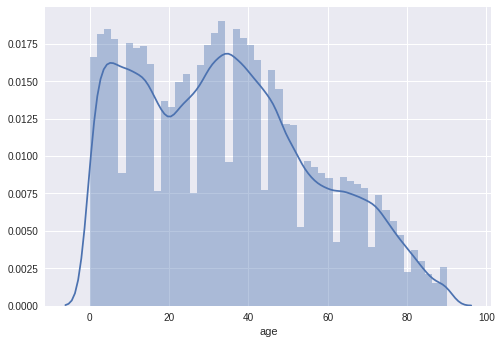

In [19]:
sns.distplot(num_train.age)

CPU times: user 114 ms, sys: 5.77 ms, total: 120 ms
Wall time: 115 ms


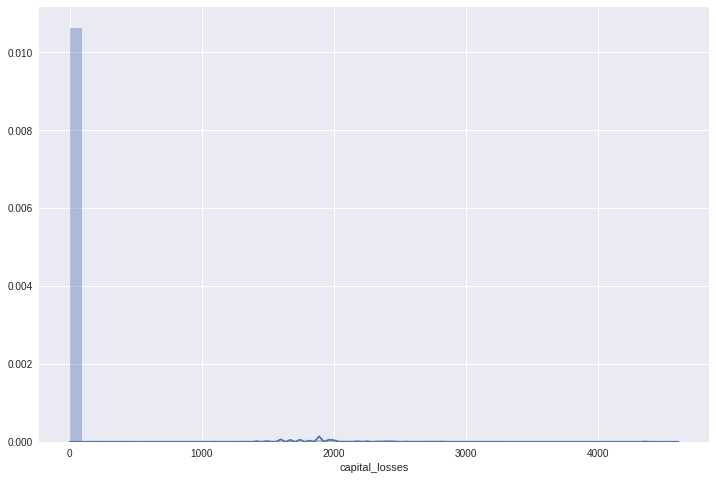

In [20]:
%%time
plt.figure(figsize=(12,8))
sns.distplot(num_train.capital_losses)

## right skewed

In [21]:
income = pd.DataFrame(train.income_level)


# we should also plot numerical variables with dependent variable. Thus creating a temporary new df with num_train and income_level combined

temp = pd.concat([num_train, income], axis=1)
temp.head(3)

,age,wage_per_hour,capital_gains,capital_losses,dividend_from_Stocks,num_person_Worked_employer,weeks_worked_in_year,income_level
0,73,0,0,0,0,0,0,0
1,58,0,0,0,0,1,52,0
2,18,0,0,0,0,0,0,0


### Data Visualization

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 9.78 µs


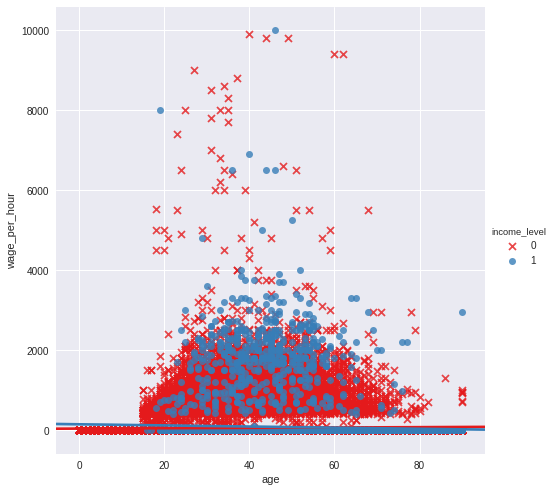

In [22]:
%time
sns.lmplot(x="age", y="wage_per_hour",hue="income_level", data=temp, palette="Set1",markers=["x", "o"], size = 7)

CPU times: user 37.3 s, sys: 6.77 s, total: 44.1 s
Wall time: 35.9 s


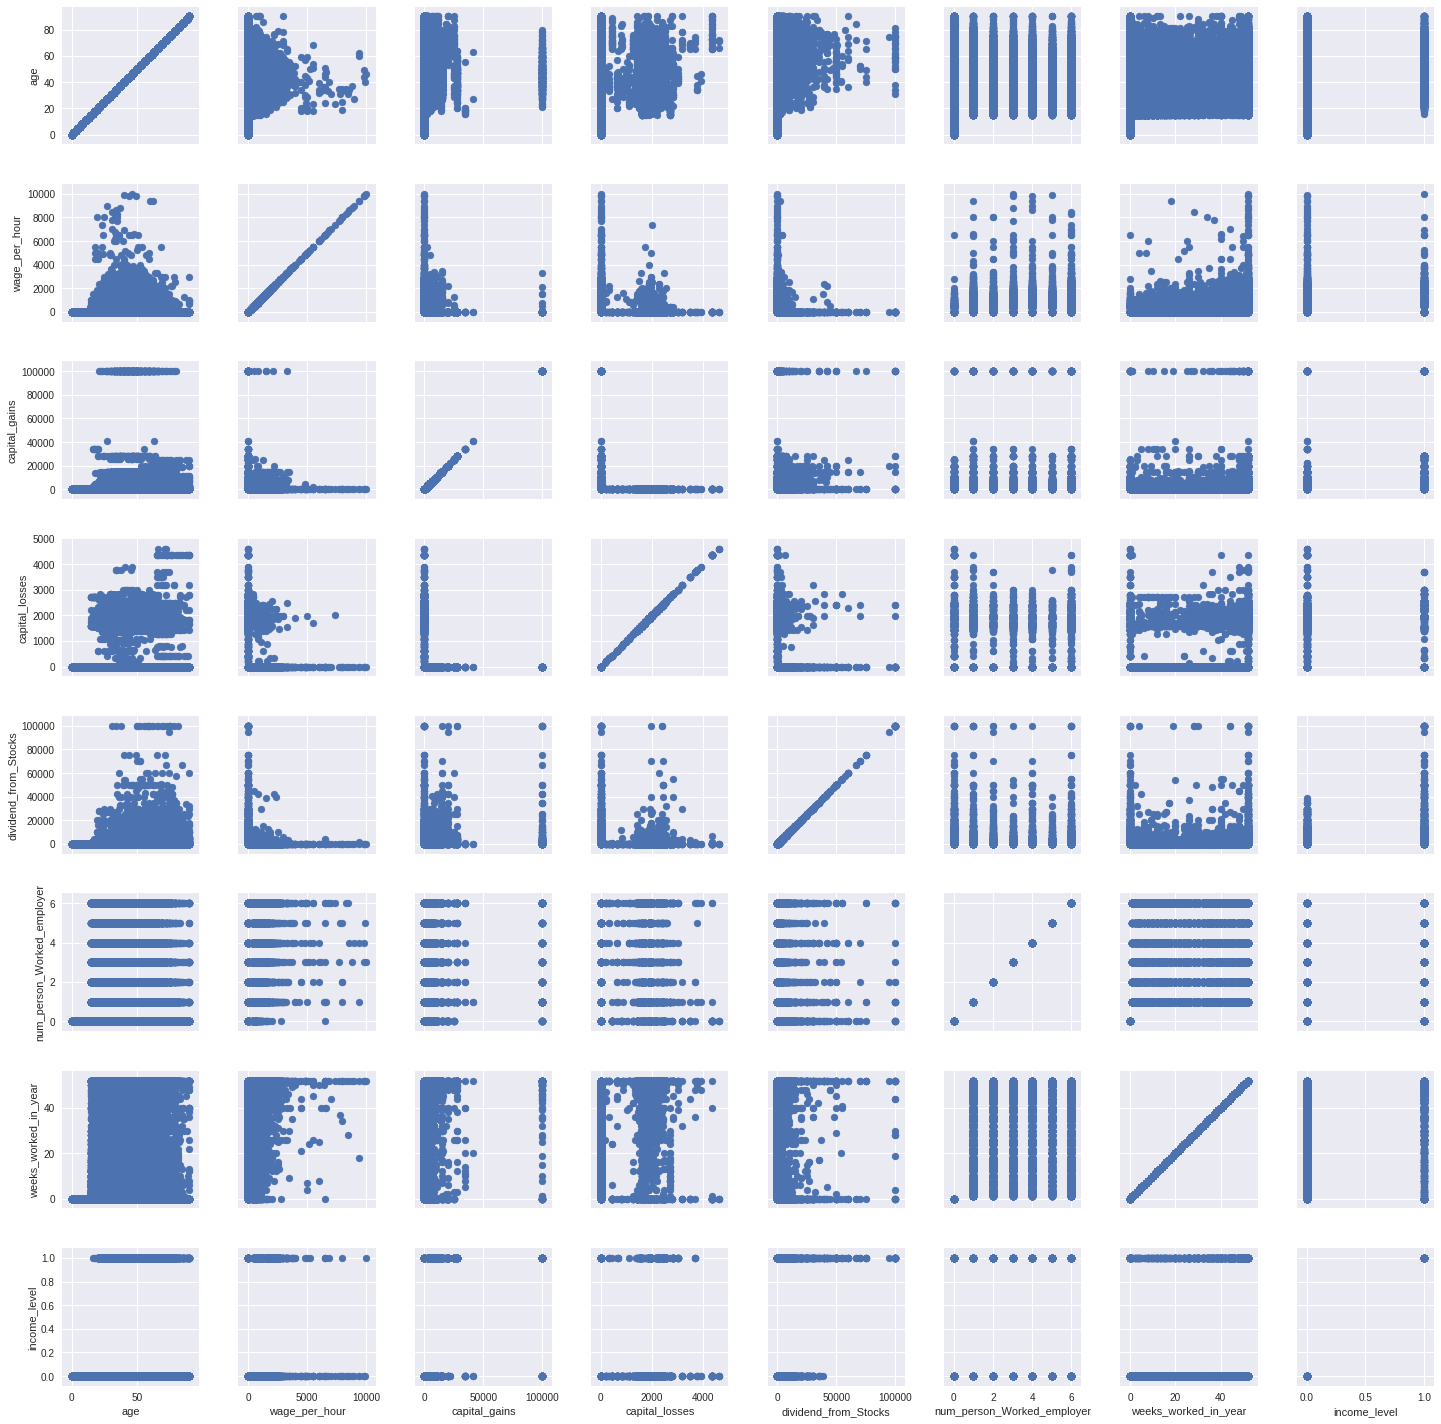

In [23]:
%%time
g = sns.PairGrid(temp)
g = g.map(plt.scatter)

CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 15.7 µs


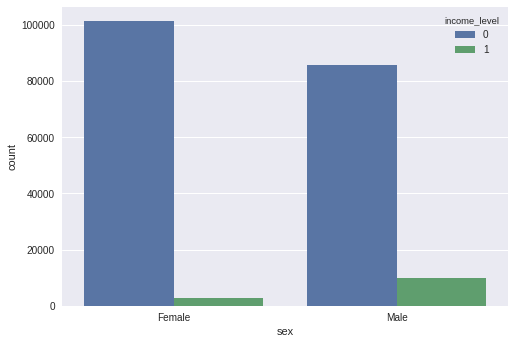

In [24]:
%time
sns.countplot(x="sex", hue="income_level", data=cat_train)

CPU times: user 278 ms, sys: 2.14 ms, total: 280 ms
Wall time: 285 ms


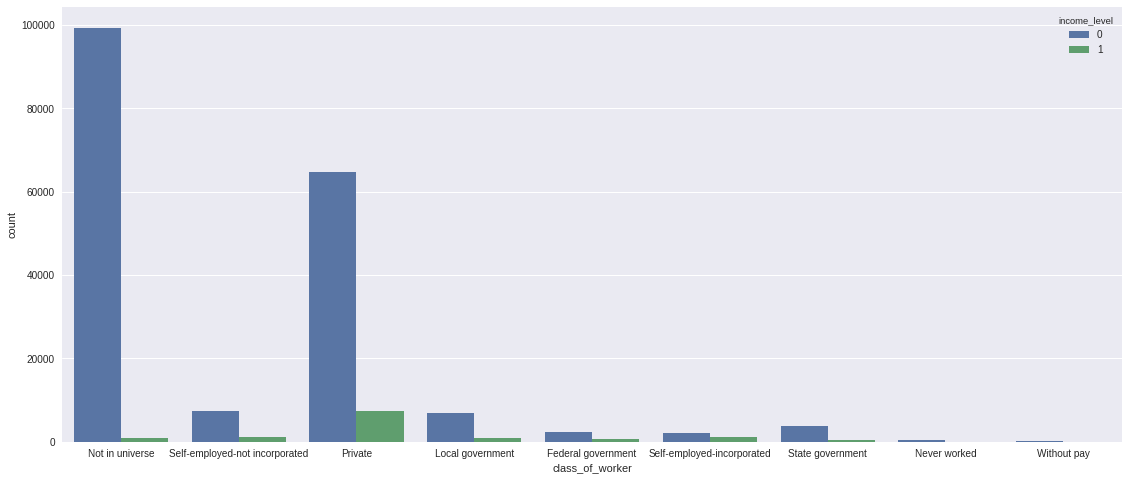

In [25]:
%%time
plt.figure(figsize=(19,8))
sns.countplot(x="class_of_worker", hue="income_level", data=cat_train)

CPU times: user 312 ms, sys: 4.29 ms, total: 316 ms
Wall time: 315 ms


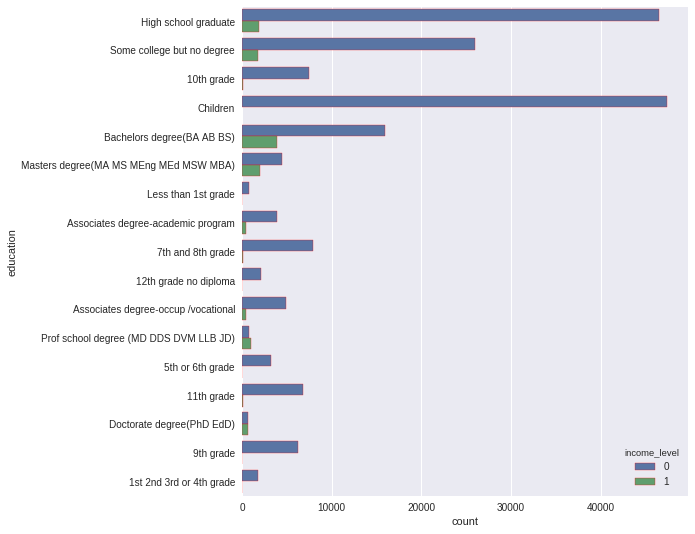

In [26]:
%%time
plt.figure(figsize = (8,9))
sns.countplot(y="education", hue="income_level", data=cat_train, edgecolor = 'r')

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 10.3 µs


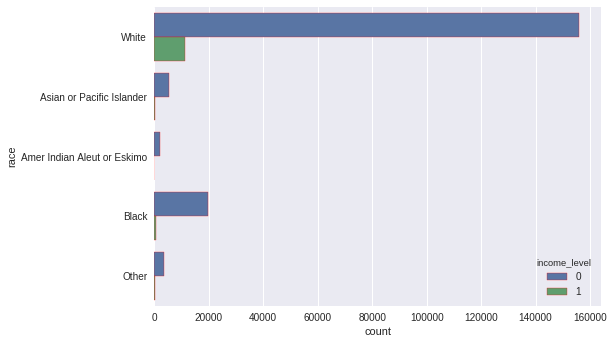

In [27]:
%time
sns.countplot(y="race", hue="income_level", data=cat_train, edgecolor = 'r')

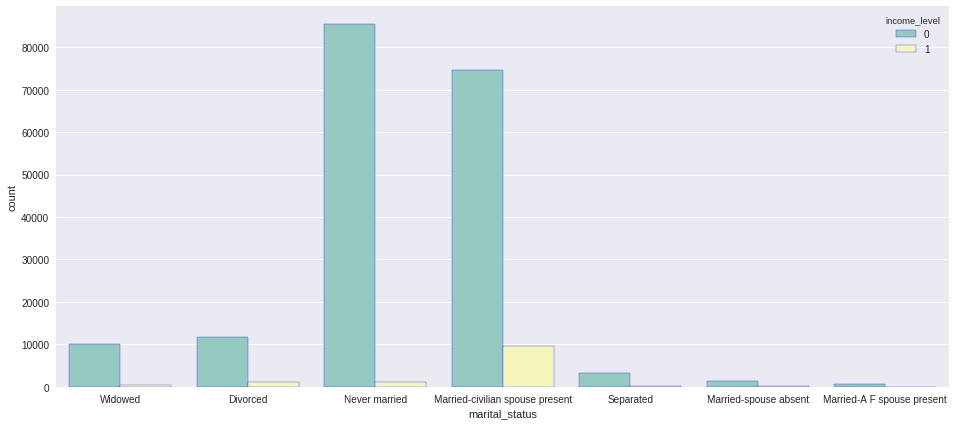

In [28]:
plt.figure(figsize = (16,7))
sns.countplot(x="marital_status", hue = 'income_level' ,data= cat_train,palette="Set3", edgecolor = 'b')

In [29]:
print(cat_train.columns)

cat_train.head(1)

Index(['class_of_worker', 'industry_code', 'occupation_code', 'education',
       'marital_status', 'major_industry_code', 'major_occupation_code',
       'race', 'hispanic_origin', 'sex', 'member_of_labor_union',
       'reason_for_unemployment', 'full_parttime_employment_stat',
       'region_of_previous_residence', 'state_of_previous_residence',
       'd_household_family_stat', 'd_household_summary', 'migration_msa',
       'migration_reg', 'migration_within_reg', 'live_1_year_ago',
       'migration_sunbelt', 'country_father', 'country_mother', 'country_self',
       'citizenship', 'business_or_self_employed',
       'fill_questionnaire_veteran_admin', 'veterans_benefits', 'year',
       'income_level', 'family_members_under_18',
       'enrolled_in_edu_inst_lastwk', 'tax_filer_status'],
      dtype='object')


,class_of_worker,industry_code,occupation_code,education,marital_status,major_industry_code,major_occupation_code,race,hispanic_origin,sex,...,country_self,citizenship,business_or_self_employed,fill_questionnaire_veteran_admin,veterans_benefits,year,income_level,family_members_under_18,enrolled_in_edu_inst_lastwk,tax_filer_status
0,Not in universe,0,0,High school graduate,Widowed,Not in universe or children,Not in universe,White,All other,Female,...,United-States,Native- Born in the United States,0,Not in universe,2,95,0,Not in universe,Not in universe,Nonfiler


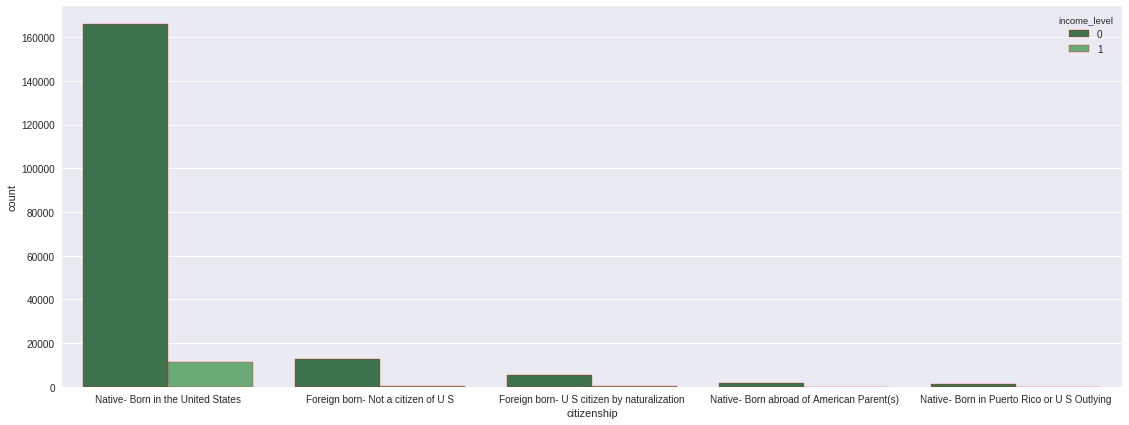

In [30]:
plt.figure(figsize = (19,7))
sns.countplot(x="citizenship",hue = 'income_level', data=cat_train, edgecolor = 'r', palette="Greens_d")

### **Data Manipulation**
path towards Machine Learning...

As we have imbalanced classifications, we should try our best to shape the data such that we can derive maximum information about minority class.

In [0]:
# num_train.weeks_worked_in_year.unique()
# num_train.family_members_under_18.unique() ## ['Not in universe', 'Both parents present', 'Mother only present','Neither parent present', 'Father only present']
# num_train.enrolled_in_edu_inst_lastwk.unique() ## ['Not in universe', 'High school', 'College or university']
# num_train.tax_filer_status.unique() ##['Nonfiler', 'Head of household', 'Joint both under 65', 'Single','Joint both 65+', 'Joint one under 65 & one 65+']

# 'family_members_under_18', 'enrolled_in_edu_inst_lastwk', 'tax_filer_status' in cat_features


# cat_train.country_self.unique()

In [0]:
# cat_train.iloc[:,17:].head()

In [33]:
cat_test.head()

,class_of_worker,industry_code,occupation_code,education,marital_status,major_industry_code,major_occupation_code,race,hispanic_origin,sex,...,country_self,citizenship,business_or_self_employed,fill_questionnaire_veteran_admin,veterans_benefits,year,income_level,family_members_under_18,enrolled_in_edu_inst_lastwk,tax_filer_status
0,Private,6,36,1st 2nd 3rd or 4th grade,Married-civilian spouse present,Manufacturing-durable goods,Machine operators assmblrs & inspctrs,White,Mexican (Mexicano),Female,...,Mexico,Foreign born- Not a citizen of U S,0,Not in universe,2,95,0,Not in universe,Not in universe,Joint one under 65 & one 65+
1,Self-employed-not incorporated,37,12,Associates degree-occup /vocational,Married-civilian spouse present,Business and repair services,Professional specialty,White,All other,Female,...,United-States,Native- Born in the United States,0,Not in universe,2,95,0,Not in universe,Not in universe,Joint both under 65
2,Not in universe,0,0,Children,Never married,Not in universe or children,Not in universe,White,Mexican-American,Male,...,United-States,Native- Born in the United States,0,Not in universe,0,95,0,Both parents present,Not in universe,Nonfiler
3,Private,29,3,High school graduate,Divorced,Transportation,Executive admin and managerial,White,All other,Female,...,United-States,Native- Born in the United States,2,Not in universe,2,94,0,Not in universe,Not in universe,Head of household
4,Private,4,34,High school graduate,Divorced,Construction,Precision production craft & repair,White,All other,Male,...,United-States,Native- Born in the United States,0,Not in universe,2,95,0,Not in universe,Not in universe,Single


In [34]:
# num_test.isnull().any().unique()
pd.__version__

'0.22.0'

In [35]:
print(cat_train.shape,cat_test.shape,num_train.shape,num_test.shape)

(199523, 34) (99762, 34) (199523, 7) (99762, 7)


In [36]:
cat_train.columns == cat_test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

**Using the One hot encoding method for vectorizing the nominal features using the get_dummies features in pandas.
get_dummies by default deletes the extra columns, thus avoiding the dummy variable trap.**

In [37]:
cat_train_dummies = pd.get_dummies(cat_train,drop_first=True)
print(cat_train_dummies.shape)

cat_test_dummies = pd.get_dummies(cat_test,drop_first=True)
print(cat_test_dummies.shape)

(199523, 365)
(99762, 373)


### *Preparing the final Train and Test datasets*

**Concatenating the separate numerical and nominal datasets into final train and test datasets.**

In [38]:
train_data = pd.concat([num_train, cat_train_dummies], axis=1)
print(train_data.shape)

test_data = pd.concat([num_test, cat_test_dummies], axis=1)
print(test_data.shape)

(199523, 372)
(99762, 380)


**Splitting train_data into Training and testing data**

In [111]:
X = train_data.drop(['income_level'], axis = 1).values
print(f'Shape of X : {X.shape}')

y = train_data['income_level'].values
print(f'Shape of y: {y.shape}')

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0, stratify = train_data['income_level'])
print(f'\n\nShape X_train: {X_train.shape}\nShape X_test: {X_test.shape}\nShape y_train: {y_train.shape}\nShape y_test: {y_test.shape}')

Shape of X : (199523, 371)
Shape of y: (199523,)


Shape X_train: (159618, 371)
Shape X_test: (39905, 371)
Shape y_train: (159618,)
Shape y_test: (39905,)


###Feature scaling

**Standardize features by removing the mean and scaling to unit variance. Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual feature do not more or less look like standard normally distributed data.**

In [0]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### **Dimensionality Reduction**

**As we have can see that we have 371 features, it is recommended to apply feature selection. After monitoring the individual performances of LDA (Linear Discriminant Analysis) and PCA (Principal component analysis), finally used PCA for higher performance.**

### PCA

In [115]:
# feature selection PCA

from sklearn.decomposition import PCA
pca = PCA(n_components=185)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

explained_var = pca.explained_variance_ratio_
print(explained_var.shape)

(185,)


In [0]:
## Checking out the total variance explained by the number of PCAs

# e_v = []
# for i in range(185):
#     e_v.append(explained_var[i])

# sum(e_v)

### Creating a base Logistic Regression model

Creating a  quick and rough base model helps incorporate the bigger picture. Once achieved, from here fine tuning can be done.

In [54]:
# Creating a base model for evaluation purpose.
%%time

from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)
print(y_pred)

# Making the Confusion Matrix adn Calculating the accuracy with it.
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm_a = np.asanyarray(cm)

[0 0 0 ... 0 0 0]
CPU times: user 1min 10s, sys: 1.69 s, total: 1min 11s
Wall time: 1min 11s


In [66]:
print('Log Reg :-')

print(f'ConMatrix:\n {cm}')


from sklearn.metrics import roc_curve, roc_auc_score, f1_score, auc, precision_recall_curve, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

print(f'Accuracy : {round(accuracy_score(y_test, y_pred),3)*100}%')

f1score = f1_score(y_test, y_pred)
print(f'F1SCore : {round(f1score,5)}')

# fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=2)
# print(fpr, tpr, thresholds)

Log Reg :-
ConMatrix:
 [[37118   311]
 [ 1640   836]]
Accuracy : 95.1%
F1SCore : 0.4615


**Creating a dataset with actual, predicted values and the model's associated predicted probabilities.**

In [56]:
df = pd.DataFrame({'y_test':y_test, 'prob_1':classifier.predict_proba(X_test)[:,0], 'prob_0': classifier.predict_proba(X_test)[:,1],'y_pred':y_pred})

df[df['y_test'] == 1].head(10)

,prob_0,prob_1,y_pred,y_test
52,0.993291,0.006709,1,1
53,0.110741,0.889259,0,1
70,0.342103,0.657897,0,1
88,0.445776,0.554224,0,1
101,0.686746,0.313254,1,1
117,0.999832,0.000168,1,1
137,0.167151,0.832849,0,1
143,0.021539,0.978461,0,1
190,0.647126,0.352874,1,1
267,0.470523,0.529477,0,1


Plotting the ROC (receiver operating characteristic) curve for default threshold value of our base binary classifiier and the AUC (area under the curve).

AUC of ROC : 0.9373880297909005


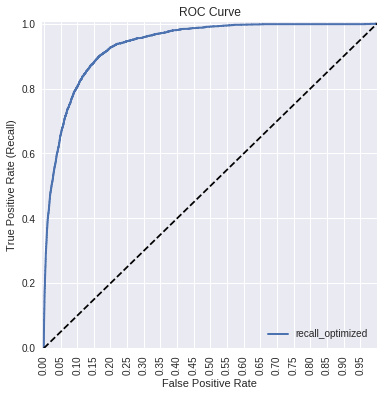

In [57]:
y_scores = classifier.predict_proba(X_test)[:,1]


def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(6,6))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")

    plt.legend(loc='best')
    
fpr, tpr, auc_thresholds = roc_curve(y_test, y_scores)
print(f'AUC of ROC : {auc(fpr, tpr)}') 


plot_roc_curve(fpr, tpr, 'recall_optimized')

In [0]:
p, r, thresholds = precision_recall_curve(y_test, y_scores)

In [0]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    print()
    adj_f1score = f1_score(y_test, y_pred_adj)
    print(f'Adj F1score     : {round(adj_f1score,5)}')
    print(f'Recall Score    : {recall_score(y_test,y_pred_adj)}')
    print(f'Precision Score : {precision_score(y_test,y_pred_adj)}\n\n')
    
    # plot the curve
    plt.figure(figsize=(6,6))
    plt.title(f"Precision and Recall curve ^ = current threshold {t} ")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.5, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',markersize=15)


     pred_neg  pred_pos
neg     36347      1082
pos      1145      1331

Adj F1score     : 0.54449
Recall Score    : 0.5375605815831987
Precision Score : 0.5515955242436801




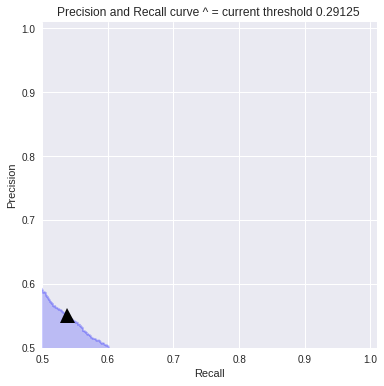

In [60]:
# After several iterations t = 0.29125 gives the best F1Score so far for our current model.

precision_recall_threshold(p, r, thresholds, t = 0.29125)

In [0]:
# precision and recall, plot them together as a function of the decision threshold.

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(6,6))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

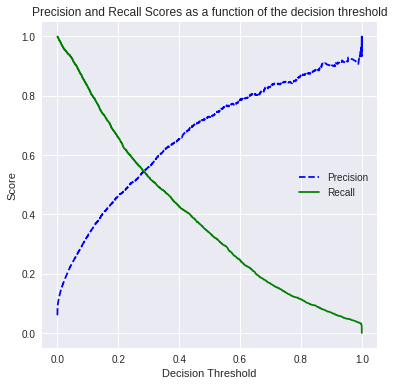

In [62]:
plot_precision_recall_vs_threshold(p, r, thresholds)

AUC of ROC : 0.9373880297909005


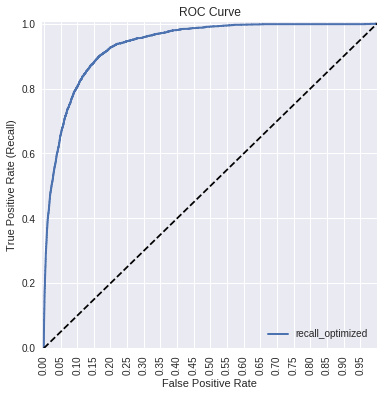

In [63]:
fpr, tpr, auc_thresholds = roc_curve(y_test, y_scores)
print(f'AUC of ROC : {auc(fpr, tpr)}') # 
plot_roc_curve(fpr, tpr, 'recall_optimized')

**Using KFold Cross Validation**

In [0]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate
# accuracies = cross_val_score(estimator=classifier,X = X_train,y = y_train, cv = 10)
scores = cross_validate(classifier, X, y, cv = 10, scoring= {'AUC': 'roc_auc', 'F1':'f1', 'Recall_score':'recall','presicion_score':'precision'})

**Our base model doesnt seem to perform well, the main reason is that it is struggling to classifiy the minority class in the test datasets which as seen earlier were distributed at 6% out of the total. Moving forward, some technique has to used to overcome this disparity in the datasets.**

In [71]:
print(sum(scores['test_presicion_score'].tolist())/len(scores['test_presicion_score'].tolist()))
print(sum(scores['test_Recall_score'].tolist())/len(scores['test_Recall_score'].tolist()))
print(sum(scores['test_AUC'].tolist())/len(scores['test_AUC'].tolist()))

0.719283948391509
0.382166294408566
0.9431009067944884


### Using combination of over - and under-sampling to deal with imbalance in the dataset

Using the "imbalanced-learn" wrapper of scikitlearn to tackle the high disparity in target's class distribution.


---


Techniques explored:


*   EasyEnsemble & BalanceCascade (Undersampling)
*   Synthetic Data Generation using SMOTEEN & SMOTETomek
---

*FInally resorted to the technique with best performance.*


---











In [39]:
X = train_data.drop(['income_level'], axis = 1).values
print(f'Shape of X : {X.shape}')

y = train_data['income_level'].values
print(f'Shape of y: {y.shape}')

Shape of X : (199523, 371)
Shape of y: (199523,)


Installing the imbalanced-learn dependency for our problem statement.

In [40]:
!pip install -U imbalanced-learn 

    100% |████████████████████████████████| 153kB 11.4MB/s 


**Quick analysis of class distribution in the target feature.**

In [41]:
from collections import Counter

print(sorted(Counter(y).items()))
print(f'Total Number of Target obs in original y: {y.shape[0]}')
print(f'% Occurence of CLass 0 : {Counter(y)[0]/y.shape[0]*100}')
print(f'% Occurence of CLass 1 : {Counter(y)[1]/y.shape[0]*100}')

[(0, 187141), (1, 12382)]
Total Number of Target obs in original y: 199523
% Occurence of CLass 0 : 93.79419916500854
% Occurence of CLass 1 : 6.205800834991455


Could have used undersampling methods for majority Class, but the tradeoff would be loss of information.


---


Thus using SMOTE ~ (synthetic minority oversampling technique) as of now. SMOTE can generate artifical samples  and this method can make the data more noisy overshadowing the valid signals.
SMOTEENN and SMOTETomek methods of the imblearn deal with this issue of noise.


---


 **As per the documentation, SMOTEENN tends to clean more noisy samples than SMOTETomek.
Thus using SMOTEENN (SMOTE with EditedNearestNeighbours).**

In [42]:
%%time


from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_sample(X, y)
print(sorted(Counter(y_resampled).items()))

[(0, 158645), (1, 183742)]
CPU times: user 1h 44min 12s, sys: 6.63 s, total: 1h 44min 18s
Wall time: 1h 44min 13s


 **It took *1h 44min 13s* to fit the data, on a Tesla K80 GPU. :-0**



---


**We can see the increase in the data size and the significant change in the class distribution.**



In [43]:
print(f'Total Number of Target obs in y_resampled : {y_resampled.shape[0]}')
print(f'% Occurence of Class 0 : {Counter(y_resampled)[0]/y_resampled.shape[0]*100}')
print(f'% Occurence of Class 1 : {Counter(y_resampled)[1]/y_resampled.shape[0]*100}')

Total Number of Target obs in y_resampled : 342387
% Occurence of Class 0 : 46.33499519549515
% Occurence of Class 1 : 53.66500480450485


In [53]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.20,
                                                    random_state = 0)  # stratify = False
print(f'\n\nShape X_train: {X_train.shape}\nShape X_test:{X_test.shape}\nShape y_train: {y_train.shape}\nShape y_test: {y_test.shape}')



Shape X_train: (273909, 371)
Shape X_test:(68478, 371)
Shape y_train: (273909,)
Shape y_test: (68478,)


**Fitting the resampled data to out log regression model, let's analyze the performance now.**

In [56]:
# SMOTE LOG REG

%%time

from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)
print(y_pred)

# Making the Confusion Matrix adn Calculating the accuracy with it.
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm_a = np.asanyarray(cm)

[0 1 1 ... 1 0 1]
CPU times: user 15.4 s, sys: 206 ms, total: 15.6 s
Wall time: 15.5 s


In [57]:
print('SMOTE Log Reg :-')

print(f'ConMatrix:\n {cm}')


from sklearn.metrics import roc_curve, roc_auc_score, f1_score, auc, precision_recall_curve, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

print(f'Accuracy : {round(accuracy_score(y_test, y_pred),3)*100}%')

f1score = f1_score(y_test, y_pred)
print(f'F1SCore : {round(f1score,5)}')

# fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=2)
# print(fpr, tpr, thresholds)

SMOTE Log Reg :-
ConMatrix:
 [[28327  3560]
 [ 2263 34328]]
Accuracy : 91.5%
F1SCore : 0.92182


AUC of ROC : 0.9712952871276368


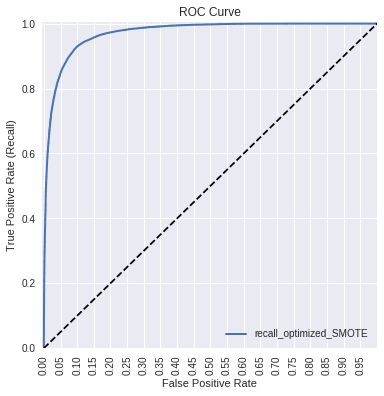

In [58]:
y_scores = classifier.predict_proba(X_test)[:,1]


def plot_roc_curve(fpr, tpr, label=None):
    
    plt.figure(figsize=(6,6))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")

    plt.legend(loc='best')
    
fpr, tpr, auc_thresholds = roc_curve(y_test, y_scores)
print(f'AUC of ROC : {auc(fpr, tpr)}') 


plot_roc_curve(fpr, tpr, 'recall_optimized_SMOTE')

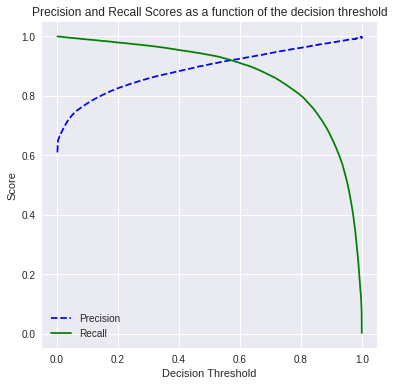

In [59]:
p, r, thresholds = precision_recall_curve(y_test, y_scores)

# precision and recall, plot them together as a function of the decision threshold.

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(6,6))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    
plot_precision_recall_vs_threshold(p, r, thresholds)

In [0]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate
# accuracies = cross_val_score(estimator=classifier,X = X_train,y = y_train, cv = 10)
scores = cross_validate(classifier, X_resampled, y_resampled, cv = 10, scoring= {'AUC': 'roc_auc', 'F1':'f1', 'Recall_score':'recall','presicion_score':'precision'})

In [52]:
print(sum(scores['test_presicion_score'].tolist())/len(scores['test_presicion_score'].tolist()))
print(sum(scores['test_Recall_score'].tolist())/len(scores['test_Recall_score'].tolist()))
print(sum(scores['test_AUC'].tolist())/len(scores['test_AUC'].tolist()))

0.9028453040758156
0.9343536535284626
0.9690306754661672


Clearly using Log regression on the resampled data has outperformed the previous model.


---

### Using XGBoost on SMOTEEN data


**Importing the XGB classifier and fitting the data.**

In [62]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

print('XGB :-')

XGB :-


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [89]:
print('XGB :-')

print(f'ConMatrix:\n {cm}')


from sklearn.metrics import roc_curve, roc_auc_score, f1_score, auc, precision_recall_curve, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

print(f'Accuracy : {round(accuracy_score(y_test, y_pred),3)*100}%')

f1score = f1_score(y_test, y_pred)
print(f'F1SCore : {round(f1score,5)}')
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f'Precision Score : {precision_score(y_test,y_pred)}')
print(f'Specificity : {tn / (tn+fp)}' )
print(f'Recall/Sensitivity  Score : {recall_score(y_test,y_pred)}')


XGB :-
ConMatrix:
 [[24522  7365]
 [ 1468 35123]]
Accuracy : 97.2%
F1SCore : 0.97348
Precision Score : 0.9729980615393016
Specificity : 0.9689842255464609
Recall/Sensitivity  Score : 0.9739553442103249


* Recall / Sensitivity = True Positive Rate (TP/TP+FN) – It says, ‘out of all the positive (majority class) values, how many have been predicted correctly’.
* Specificity = True Negative Rate (TN/TN +FP) – It says, ‘out of all the negative (minority class) values, how many have been predicted correctly’.
* Precision = (TP/TP+FP)
* F score = 2 * (Precision * Recall)/ (Precision + Recall) – It is the harmonic mean of precision and recall. It is used to compare several models side-by-side. Higher the better.


**As we need to know if we are predicting minority class correctly, we can look at the model's Specificity and Sensitivity scores and it is evident that they are on point.**

AUC of ROC : 0.9604593419139413


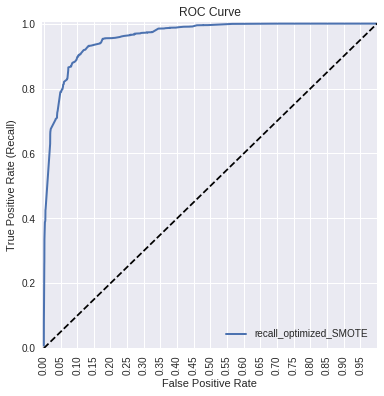

In [86]:
y_scores = model.predict_proba(X_test)[:,1]


def plot_roc_curve(fpr, tpr, label=None):
    
    plt.figure(figsize=(6,6))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")

    plt.legend(loc='best')
    
fpr, tpr, auc_thresholds = roc_curve(y_test, y_scores)
print(f'AUC of ROC : {auc(fpr, tpr)}') 


plot_roc_curve(fpr, tpr, 'recall_optimized_SMOTE')

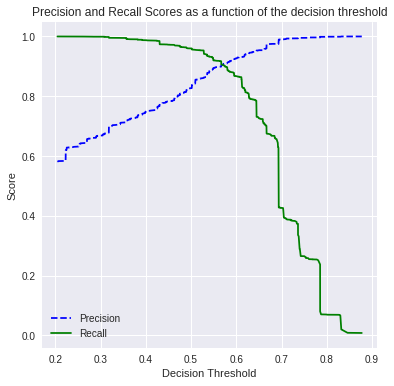

In [87]:
p, r, thresholds = precision_recall_curve(y_test, y_scores)

# precision and recall, plot them together as a function of the decision threshold.

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(6,6))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    
plot_precision_recall_vs_threshold(p, r, thresholds)

**Using KFold cross validation, to ensure the skill of our XGBoost model on new data.**

In [0]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate
scores = cross_validate(xgb, X, y, cv = 10, scoring= {'AUC': 'roc_auc', 'F1':'f1', 'Recall_score':'recall','presicion_score':'precision'})

In [73]:
print('presicion_score :' ,sum(scores['test_presicion_score'].tolist())/len(scores['test_presicion_score'].tolist()))
print('Recall_score :', sum(scores['test_Recall_score'].tolist())/len(scores['test_Recall_score'].tolist()))
print('AUC :', sum(scores['test_AUC'].tolist())/len(scores['test_AUC'].tolist()))
print('F1 Score :', sum(scores['test_F1'].tolist())/len(scores['test_F1'].tolist()))

presicion_score : 0.9726901641636824
Recall_score : 0.9653491616740307
AUC : 0.9960748806641544
F1 Score : 0.9675699955083215
